<a href="https://colab.research.google.com/github/Rhicarde/CECS-574---ZKML/blob/main/ZKML_for_Privacy_Preservation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset
View dataset from kaggle [here](https://www.kaggle.com/datasets/ankushpanday2/heart-attack-risk-and-prediction-dataset-in-india/data).

The dataset used is representing medical and lifestyle risk factors that may lead to heart diseases. We will be using it to train a model that can ideally predict early signs of heart diseases based on the given factors.

In [1]:
# Downloading Dataset
import kagglehub

path = kagglehub.dataset_download("ankushpanday2/heart-attack-risk-and-prediction-dataset-in-india")

print("Path to dataset files:", path)

100%|██████████| 269k/269k [00:00<00:00, 20.9MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/ankushpanday2/heart-attack-risk-and-prediction-dataset-in-india/versions/1


In [2]:
import pandas as pd

df = pd.read_csv(path + '/heart_attack_prediction_india.csv')
df.head()

,Patient_ID,State_Name,Age,Gender,Diabetes,Hypertension,Obesity,Smoking,Alcohol_Consumption,Physical_Activity,...,Diastolic_BP,Air_Pollution_Exposure,Family_History,Stress_Level,Healthcare_Access,Heart_Attack_History,Emergency_Response_Time,Annual_Income,Health_Insurance,Heart_Attack_Risk
0,1,Rajasthan,42,Female,0,0,1,1,0,0,...,119,1,0,4,0,0,157,611025,0,0
1,2,Himachal Pradesh,26,Male,0,0,0,0,1,1,...,115,0,0,7,0,0,331,174527,0,0
2,3,Assam,78,Male,0,0,1,0,0,1,...,117,0,1,10,1,0,186,1760112,1,0
3,4,Odisha,58,Male,1,0,1,0,0,1,...,65,0,0,1,1,1,324,1398213,0,0
4,5,Karnataka,22,Male,0,0,0,0,0,1,...,109,0,0,9,0,0,209,97987,0,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Patient_ID               10000 non-null  int64 
 1   State_Name               10000 non-null  object
 2   Age                      10000 non-null  int64 
 3   Gender                   10000 non-null  object
 4   Diabetes                 10000 non-null  int64 
 5   Hypertension             10000 non-null  int64 
 6   Obesity                  10000 non-null  int64 
 7   Smoking                  10000 non-null  int64 
 8   Alcohol_Consumption      10000 non-null  int64 
 9   Physical_Activity        10000 non-null  int64 
 10  Diet_Score               10000 non-null  int64 
 11  Cholesterol_Level        10000 non-null  int64 
 12  Triglyceride_Level       10000 non-null  int64 
 13  LDL_Level                10000 non-null  int64 
 14  HDL_Level                10000 non-null

# Training Model

The model that is used is a simple logistic regression model from Sklearn and then converted to a Tensor Model. A logistic regression model estimates the probability of an event, in this case heart disease, occuring using the given data.

The model trained gets a prediction accuracy rate of 71.75%.

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Split Dataset
x = df.drop('Heart_Attack_Risk', axis=1)
y = df['Heart_Attack_Risk']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

ct = ColumnTransformer(
    transformers= [('onehot', OneHotEncoder(drop='first'), ['State_Name', 'Gender']), # Expands number of features thrugh one hot encoding (0, 1)
                   ('normal', StandardScaler(),
                    ['Diastolic_BP', 'Annual_Income', 'Emergency_Response_Time', 'Systolic_BP', 'Cholesterol_Level', 'Triglyceride_Level', 'LDL_Level', 'HDL_Level']) # Keeps feature count the same
                  ], remainder='passthrough') # Remaining columns kept as they are (no transformation)

x_train = ct.fit_transform(x_train)
x_test = ct.transform(x_test)

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Logistic Regression Model
model = LogisticRegression(max_iter=2000)

# Train Model
model.fit(x_train, y_train)

# Test Model Accuracy
y_pred = model.predict(x_test)
print(f'Accuracy Score: {accuracy_score(y_test, y_pred) * 100}%')

Accuracy Score: 71.75%


In [6]:
import torch
import torch.nn as nn


class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

In [7]:
# Convert to Torch Model for EZKL

# Get sklearn model weights and bias
weights = model.coef_  # Shape: (1, n_features)
bias = model.intercept_  # Shape: (1,)

# Create Torch model
input_dim = x_train.shape[1]
torch_model = LogisticRegression(input_dim)

# Convert sklearn weights to PyTorch tensors and assign them
torch_model.linear.weight = nn.Parameter(torch.tensor(weights, dtype=torch.float32))
torch_model.linear.bias = nn.Parameter(torch.tensor(bias, dtype=torch.float32))

In [8]:
# Testing torch model to ensure same result

# Convert test data to tensor
x_test_torch = torch.tensor(x_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test.tolist(), dtype=torch.float32)

torch_model.eval()

with torch.no_grad():
  # Get model predictions and convert them to int (0 or 1 tells us no or yes to heart disease risk)
  y_pred_probs = torch_model(x_test_torch).squeeze()
  y_pred_labels = (y_pred_probs >= 0.5).int()  # Convert to binary labels

# Check accuracy
accuracy = accuracy_score(y_test_torch, y_pred_labels.numpy())  # Compare with true labels

print(f"PyTorch Accuracy: {accuracy * 100:.2f}%")

PyTorch Accuracy: 71.75%


# Implementing EZKL circuit

In [9]:
# check if notebook is in colab
try:
    import google.colab
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ezkl"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "onnx"])

# rely on local installation of ezkl if the notebook is not in colab
except:
    pass

import os
import json
import ezkl

In [10]:
# Required Files for EZKL
model_path = os.path.join('network.onnx')
data_path = os.path.join('input.json')
cal_data_path = os.path.join('calibration.json')

In [11]:
# Create a random input
x = torch.tensor(x_test[0], dtype=torch.float32).unsqueeze(0)

In [12]:
# Convert model to ONNX

# Export the model
torch.onnx.export(torch_model,                                   # model being run
                  x,                                             # model input
                  model_path,                                    # where to save the model
                  export_params=True,                            # store the trained parameter weights inside the model file
                  opset_version=10,                              # the ONNX version to export the model to
                  do_constant_folding=True,                      # whether to execute constant folding for optimization
                  input_names = ['input'],                       # the model's input names
                  output_names = ['output'],                     # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

data_array = ((x).detach().numpy()).reshape([-1]).tolist()

data = dict(input_data = [data_array])

# Serialize data into file:
json.dump(data, open(data_path, 'w'))

In [13]:
!RUST_LOG=trace
# TODO: Dictionary outputs
res = ezkl.gen_settings()
assert res == True

In [14]:
# use the test set to calibrate the circuit
cal_data = dict(input_data = x_test_torch.flatten().tolist())

# Serialize calibration data into file:
json.dump(data, open(cal_data_path, 'w'))

# Optimize for resources, we cap logrows at 12 to reduce setup and proving time, at the expense of accuracy
# You may want to increase the max logrows if accuracy is a concern
res = await ezkl.calibrate_settings(target = "resources", max_logrows = 50, scales = [14])


 <------------- Numerical Fidelity Report (input_scale: 14, param_scale: 14, scale_input_multiplier: 1) ------------->

+-------------+--------------+-------------+-------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| mean_error  | median_error | max_error   | min_error   | mean_abs_error | median_abs_error | max_abs_error | min_abs_error | mean_squared_error | mean_percent_error | mean_abs_percent_error |
+-------------+--------------+-------------+-------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| 0.025770724 | 0.025770724  | 0.025770724 | 0.025770724 | 0.025770724    | 0.025770724      | 0.025770724   | 0.025770724   | 0.0006641302       | 0.07327505         | 0.07327505             |
+-------------+--------------+-------------+-------------+----------------+------------------+---------

In [15]:
# Compiles Onnx model to format for ZKP
res = ezkl.compile_circuit()
assert res == True

In [16]:
# SRS is a cryptographic setup that is required for proof generation
res = await ezkl.get_srs()

In [17]:
# Sets up Circuit - generates the proving and verifying keys
res = ezkl.setup()
assert res == True

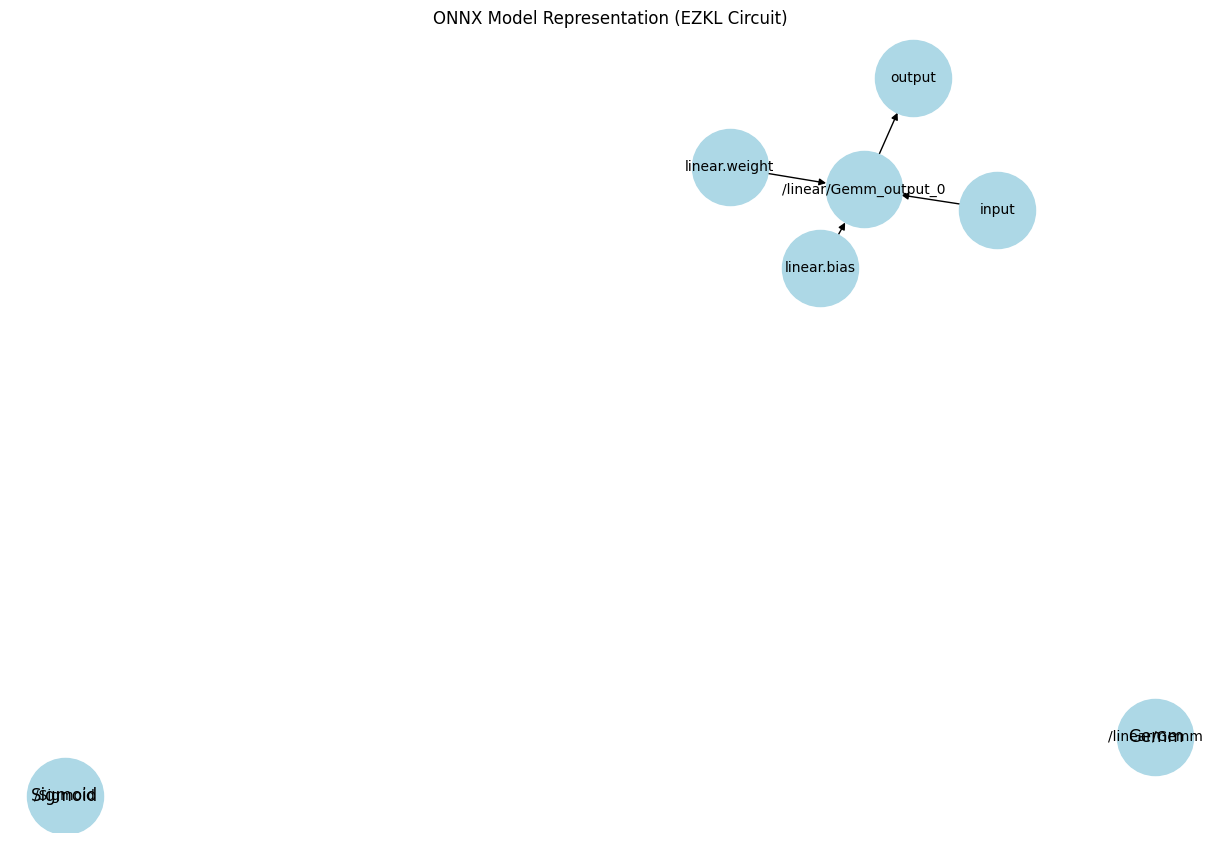

In [18]:
import onnx
import networkx as nx
import matplotlib.pyplot as plt

# Load ONNX model
model = onnx.load("network.onnx")
graph = model.graph

# Create a directed graph
G = nx.DiGraph()

# Add nodes (layers/operations)
for node in graph.node:
    G.add_node(node.name, label=node.op_type)

# Add edges (connections between layers)
for node in graph.node:
    for input_name in node.input:
        for output_name in node.output:
            G.add_edge(input_name, output_name)

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
labels = nx.get_node_attributes(G, "label")
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10)
nx.draw_networkx_labels(G, pos, labels)
plt.title("ONNX Model Representation (EZKL Circuit)")
plt.show()

# Create Witness
The witness represents the input data nad intermediate values of the circuit (weights, bias) that prove the correctness of the computation

In [19]:
# Generate the Witness for the proof

# Generate the witness file
witness_path = os.path.join('witness.json')

res = await ezkl.gen_witness()
assert os.path.isfile(witness_path)

In [20]:
# Generate the proof
proof_path = os.path.join('proof.json')

proof = ezkl.prove(proof_type="single", proof_path=proof_path) # Generate a single proof

print(proof)
assert os.path.isfile(proof_path)

{'instances': [['dc14000000000000000000000000000000000000000000000000000000000000']], 'proof': '0x1c0a16f2beeb22b86a797ba7953c33b21a9f2a9946aa7135f1edbd3954eb78c62c965a5624e33d71f063184bcef2766404886c5471fa028edfe7cba1c6ed647c257673cdee3d89e5f667c5526e804dee370af811039e034bdcb6b686e04a5d9f16a817e9683322b2a08ec20382d84ad77587429d3c8e72cf66e9549a09b3dfd511dcc881cf4f1e0e6048000681ed3292c4d42f349c5348ac4dce85a3244c823d1a9d0cd69757d357a74b5fc42be0af613a5ba625ef974e954e412efb796f959909ba731eef0d64b7717cd103ec89cc56ff38d2257e9eed654e23b86c8058d44f1f56410a619f864dfeafac1abb167c9de52f96e92c57bd1956aa31464a4bf79f0078a88b12d53ec74bf9de8309933be7b18d48947b8ea34b89d7e4ab8f46ae4b0d0332085aa53198ade239db2b2023d2e4cb7fae41b414600fe004c81607f64717c9a3f993b1787e5ceee773efe316b81db01cb5e8e6c426f9d98594f049373d1ed53cc1d4b2843cc50b6b37533bc7ca8d27daf0204fefb0915b9d1cbec0761100577c5dc7510b687fd03b40c8718ca1b8a1330daa170d56349c5a79de6d10f90593096b71407e34ff579ee7b86792ea873f58f24933247328a34c3e0d1f91180a0a3b

In [21]:
# Verify proof
res = ezkl.verify()

assert res == True # Proof verified if passed
print("verified")

verified


In [22]:
# Load the witness file
witness_path = "witness.json"

with open(witness_path, "r") as f:
    witness_data = json.load(f)

# Extract the model’s output from the witness
model_output = witness_data.get("outputs", [])

# Print the extracted prediction
print("Model Prediction:", model_output[0][0])

Model Prediction: dc14000000000000000000000000000000000000000000000000000000000000


In [23]:
import struct

# Convert hex to bytes
byte_data = bytes.fromhex(model_output[0][0])

# Convert bytes to a float (assuming IEEE 754 double-precision format)
predicted_prob = struct.unpack('d', byte_data[:8])[0]

# Print the prediction probability
print("Predicted Probability:", predicted_prob)

# Convert probability to class label (0 or 1)
predicted_class = 1 if predicted_prob >= 0.5 else 0
print("Predicted Risk:", predicted_class)

Predicted Probability: 2.6383e-320
Predicted Risk: 0


In [24]:
# Get model prediction on same data
i = 0

y_pred = torch_model(x_test_torch[i]).squeeze()

print("Predicted Risk:", 1 if y_pred.item() > 0.5 else 0)

Predicted Risk: 0


# Create Verifier

In [25]:
# Check if notebook is in colab
try:
    import google.colab
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "solc-select"])
    !solc-select install 0.8.20
    !solc-select use 0.8.20
    !solc --version

# Rely on local installation if the notebook is not in colab
except:
    pass

Installing solc '0.8.20'...
Version '0.8.20' installed.
Switched global version to 0.8.20
solc, the solidity compiler commandline interface
Version: 0.8.20+commit.a1b79de6.Linux.g++


In [26]:
# Generates smart contract with contains the logic for verifying ZK proofs on Ethereum
sol_code_path = os.path.join('Verifier.sol')
abi_path = os.path.join('Verifier.abi')

# Compiles a Solidity verifier based on the EZKL-generated proof system
res = await ezkl.create_evm_verifier(
        sol_code_path=sol_code_path,
        abi_path=abi_path,
    )

assert res == True
assert os.path.isfile(sol_code_path)

In [27]:
# Public inputs that the Ethereum smart contract will use for verification

onchain_input_array = []

formatted_output = "["
for i, value in enumerate(proof["instances"]):
    for j, field_element in enumerate(value):
        onchain_input_array.append(ezkl.felt_to_big_endian(field_element))
        formatted_output += '"' + str(onchain_input_array[-1]) + '"'
        if j != len(value) - 1:
            formatted_output += ", "
    if i != len(proof["instances"]) - 1:
        formatted_output += ", "
formatted_output += "]"

# This will be the values you use onchain
# Copy them over to remix and see if they verify
# What happens when you change a value?
print("pubInputs: ", formatted_output)
print("proof: ", proof["proof"])

pubInputs:  ["0x00000000000000000000000000000000000000000000000000000000000014dc"]
proof:  0x1c0a16f2beeb22b86a797ba7953c33b21a9f2a9946aa7135f1edbd3954eb78c62c965a5624e33d71f063184bcef2766404886c5471fa028edfe7cba1c6ed647c257673cdee3d89e5f667c5526e804dee370af811039e034bdcb6b686e04a5d9f16a817e9683322b2a08ec20382d84ad77587429d3c8e72cf66e9549a09b3dfd511dcc881cf4f1e0e6048000681ed3292c4d42f349c5348ac4dce85a3244c823d1a9d0cd69757d357a74b5fc42be0af613a5ba625ef974e954e412efb796f959909ba731eef0d64b7717cd103ec89cc56ff38d2257e9eed654e23b86c8058d44f1f56410a619f864dfeafac1abb167c9de52f96e92c57bd1956aa31464a4bf79f0078a88b12d53ec74bf9de8309933be7b18d48947b8ea34b89d7e4ab8f46ae4b0d0332085aa53198ade239db2b2023d2e4cb7fae41b414600fe004c81607f64717c9a3f993b1787e5ceee773efe316b81db01cb5e8e6c426f9d98594f049373d1ed53cc1d4b2843cc50b6b37533bc7ca8d27daf0204fefb0915b9d1cbec0761100577c5dc7510b687fd03b40c8718ca1b8a1330daa170d56349c5a79de6d10f90593096b71407e34ff579ee7b86792ea873f58f24933247328a34c3e0d1f91180a0a3b13d17